In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv')

In [3]:
data

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


In [4]:
print(data.isnull().sum())

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64


In [5]:
data = data.dropna(subset=['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g','species'])

In [6]:
X = data[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']].values
y_str = data['species'].values

In [7]:
le = LabelEncoder()
y = le.fit_transform(y_str)

In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

In [10]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

In [11]:
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size)

In [12]:
class PenguinMLP(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, output_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden2, output_dim)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PenguinMLP(input_dim=4).to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [14]:
n_epochs = 50
train_losses = []
test_accuracies = []

for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    
    # 에폭별 테스트 정확도 측정
    model.eval()
    correct = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
    accuracy = 100 * correct / len(test_loader.dataset)
    test_accuracies.append(accuracy)
    
    if epoch % 10 == 0 or epoch == 1:
        print(f'Epoch {epoch}/{n_epochs} — Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Epoch 1/50 — Loss: 1.0367, Test Accuracy: 73.91%
Epoch 10/50 — Loss: 0.2414, Test Accuracy: 97.10%
Epoch 20/50 — Loss: 0.0735, Test Accuracy: 100.00%
Epoch 30/50 — Loss: 0.0491, Test Accuracy: 100.00%
Epoch 40/50 — Loss: 0.0472, Test Accuracy: 100.00%
Epoch 50/50 — Loss: 0.0343, Test Accuracy: 100.00%


In [15]:
all_labels = []
all_preds = []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(dim=1)
        all_labels.extend(yb.numpy())
        all_preds.extend(preds.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

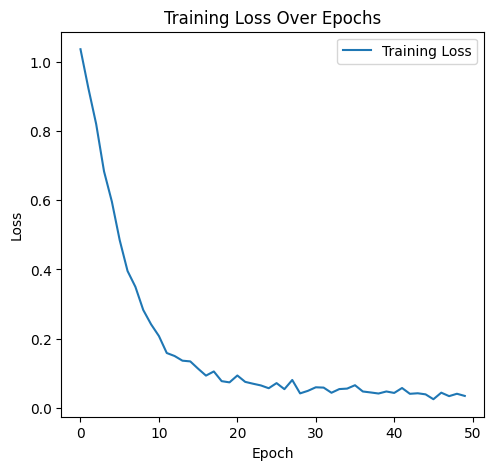

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

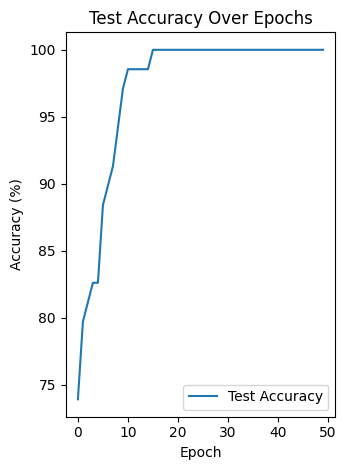

In [17]:
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

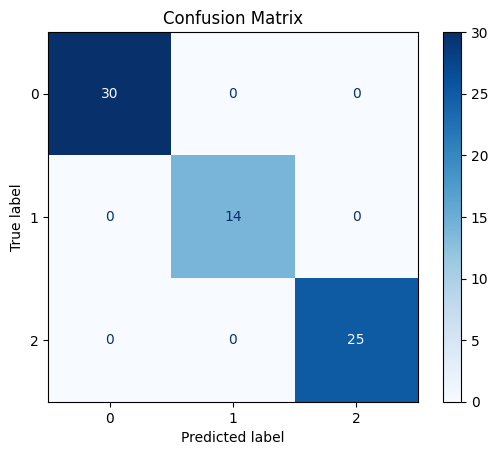

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()